## Reactor cell calculation with on-the-fly thermal scattering
This example is based on the simplified [TRIGA model](https://github.com/mit-crpg/openmc-reactor-examples/blob/main/TRIGA.ipynb) from MIT-CRPG. We compare the results of calculations using the ZrH2 ENDF/B scattering kernel with a simple NCrystal material which is generated created here, and used to include thermal scattering computed on the fly at the required temperature.

The example uses [OpenMC](https://docs.openmc.org/en/stable/) and [NCrystal](https://github.com/mctools/ncrystal/wiki). At time of writing, support for NCrystal needs to be enabled in cmake when OpenMC is compiled. The instructions are available in the [OpenMC documentation](https://docs.openmc.org/en/stable/usersguide/install.html), and we have a example installation script in Linux [here](https://github.com/marquezj/openmc_ncrystal_examples/blob/main/install.txt).

Further examples of NCrystal utilization are available [in this repository](https://github.com/mctools/ncrystal-notebooks/)

_Disclaimer: both the reactor calculation and the ZrH2 model are simplified and meant for demostrationpurposes._

In [1]:
import numpy as np
import openmc
import os
import NCrystal as NC
import matplotlib.pyplot as plt

In [2]:
openmc.config['cross_sections'] = '/home/marquezj/work/data/endfb-viii.0-hdf5/cross_sections.xml'

In [3]:
endf_results = []
ncmat_results = []
ncmat2endf_results = []

We start by creating a function that returns an OpenMC model for a reflected, 2D cell based on the TRIGA reactor fuel. This reactor cell contains a mixture of uranium and zirconium hydride as fuel, a central zirconium rod, stainless steel cladding and cooling water. The material that fills the fuel is a parameter.

In [4]:
def create_model(fuel_mat):
    # Materials definitions

    # Borated water
    water = openmc.Material(name='Water')
    water.set_density('g/cm3', 1.0)
    water.add_nuclide('H1', 2)
    water.add_nuclide('O16', 1)
    water.add_s_alpha_beta('c_H_in_H2O')

    # Stainless steel
    ss304 = openmc.Material(name='Stainless Steel')
    ss304.set_density('g/cm3', 8.0)
    ss304.add_element('Cr',.18,'wo')
    ss304.add_element('Fe',.74,'wo')
    ss304.add_element('Ni',.08,'wo')

    zirconium = openmc.Material(name='Zirconium')
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.506)

    # Instantiate a Materials collection and export to xml
    materials = openmc.Materials([zirconium, ss304, fuel_mat, water])

    # Geometry definitions for the fuel rod
    rod_outer_radius = openmc.ZCylinder(r=0.635)
    uzrh_outer_radius = openmc.ZCylinder(r=3.6449)
    molybdenum_outer_radius = openmc.ZCylinder(r=3.6449)
    ss304_outer_radius = openmc.ZCylinder(r=3.6449)
    clad_outer_radius = openmc.ZCylinder(r=3.75412)

    BOXSIZE = 4.5 
    box_x_min = openmc.XPlane(x0=-BOXSIZE, boundary_type='reflective')
    box_x_max = openmc.XPlane(x0=BOXSIZE, boundary_type='reflective')

    box_y_min = openmc.YPlane(y0=-BOXSIZE, boundary_type='reflective')
    box_y_max = openmc.YPlane(y0=BOXSIZE, boundary_type='reflective')

    # Create a Universe to encapsulate the fuel rod
    fuel_universe = openmc.Universe(name='UZrH Fuel Universe')

    # Create rod cell
    rod_cell = openmc.Cell(name='Zr Rod')
    rod_cell.fill = zirconium
    rod_cell.region = -rod_outer_radius
    fuel_universe.add_cell(rod_cell)

    # Create uzrh cell
    uzrh_cell = openmc.Cell(name='UZrH')
    uzrh_cell.fill = fuel_mat
    uzrh_cell.region = +rod_outer_radius & -uzrh_outer_radius
    fuel_universe.add_cell(uzrh_cell)

    # Create clad cell
    clad_cell = openmc.Cell(name='Stainless Steel 304 Cladding')
    clad_cell.fill = ss304
    clad_cell.region = -clad_outer_radius & +ss304_outer_radius 
    fuel_universe.add_cell(clad_cell)

    water_cell = openmc.Cell(name = "Water Upper")
    water_cell.fill = water
    water_cell.region = +clad_outer_radius & (-box_x_max & +box_x_min & -box_y_max & +box_y_min)
    fuel_universe.add_cell(water_cell)

    geometry = openmc.Geometry(fuel_universe)

    # OpenMC simulation parameters

    batches = 100
    inactive = 10
    particles = 50000

    settings = openmc.Settings()
    settings.batches = batches
    settings.inactive = inactive
    settings.particles = particles
    settings.temperature = {'multipole':True, 'method':'interpolation'}

    bounds = [-5.0, -5.0, -115.0, 5.0, 5.0,0.1]
    uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:])
    settings.source = openmc.IndependentSource(space=uniform_dist, constraints={'fissionable':True})

    return openmc.Model(geometry, materials, settings)

We now create the model for a typical fuel composition at room temperature:

In [5]:
# 20% enriched uranium zirconium hydride fuel: 12 w% U + 88 w% ZrH2

uzrh = openmc.Material(name='UZrH')
uzrh.set_density('g/cm3', 6.128)
uzrh.add_nuclide('U235', 3.506972E-03, 'ao')
uzrh.add_nuclide('U238', 1.402789E-02, 'ao')
uzrh.add_element('H',    6.549768E-01, 'ao')
uzrh.add_element('Zr',   3.274884E-01, 'ao')
uzrh.temperature = 293 # K
uzrh.add_s_alpha_beta('c_H_in_ZrH')

model = create_model(uzrh)
model.export_to_xml()

We can plot the geometry, which is infinite in the z direction:

<Axes: xlabel='y [cm]', ylabel='z [cm]'>

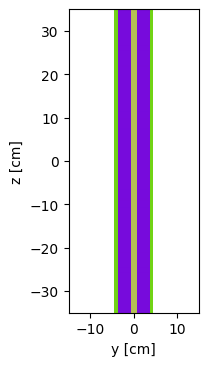

In [6]:
# Plotting fuel rod
root = model.geometry.root_universe
root.plot(width=(30, 70), origin=[0,0, 0], basis='yz')

An xy cut shows the reactor cell. The borders of the square have reflective boundary conditions:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

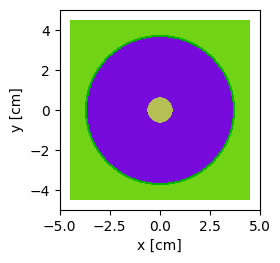

In [7]:
root.plot(width=(10, 10), origin=[0,0,0], basis='xy')

We can run it and obtain the infinite multiplication factor:

In [8]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
endf_results.append((uzrh.temperature, sp.keff.nominal_value,sp.keff.std_dev))

runtime = 37.39 s
keff = 1.3351+/-0.0004


We can change the temperature, create the model, and run again:

In [9]:
uzrh.temperature = 323 # K
uzrh.add_s_alpha_beta('c_H_in_ZrH')

model = create_model(uzrh)
model.export_to_xml()

In [10]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
endf_results.append((uzrh.temperature, sp.keff.nominal_value,sp.keff.std_dev))

runtime = 38.36 s
keff = 1.3324+/-0.0005


In [11]:
uzrh.temperature = 373 # K
uzrh.add_s_alpha_beta('c_H_in_ZrH')

model = create_model(uzrh)
model.export_to_xml()

In [12]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
endf_results.append((uzrh.temperature, sp.keff.nominal_value,sp.keff.std_dev))

runtime = 35.96 s
keff = 1.3284+/-0.0005


Here OpenMC is relying on the precomputed scattering kernels available within in the 'H(ZrH)' thermal scattering file. We can check the temperature values by accessing the file:

In [13]:
fn = '/home/marquezj/work/data/endfb-viii.0-hdf5/neutron/c_H_in_ZrH.h5'
data = openmc.data.ThermalScattering.from_hdf5(fn)

In [14]:
data.temperatures

['1000K', '1200K', '296K', '400K', '500K', '600K', '700K', '800K']

For intermediate temperatures, OpenMC interpolates according to the parameters in `settings.temperature`. But, the limit of this interpolation is the range of nuclear data available in the library:

In [15]:
uzrh.temperature = 275 # K
uzrh.add_s_alpha_beta('c_H_in_ZrH')

model = create_model(uzrh)
model.export_to_xml()

In [16]:
openmc.run(output=False)

RuntimeError: Nuclear data library does not contain cross sections for c_H_in_ZrH at temperatures that bound 275 K.

## Developing a simple ZrH2 NCrystal model

We will start by loading [the structure for ZrH2 from the Materials Project database](https://materialsproject.org/materials/mp-24286). Access to Materials Project requires an API key. If it is not available, we have the CIF information as a backup for the example:

In [17]:
import os
os.environ['MATERIALSPROJECT_USER_API_KEY'] = 'my_32_character_key'
os.environ['NCRYSTAL_ONLINEDB_CACHEDIR'] = './ncrystal_onlinedb_filecache'

In [18]:
import NCrystal.cifutils as nccif
import NCrystal.plot as ncplot

try:
    cifsrc = nccif.CIFSource('mpid::24286')
    a = cifsrc.load_data()
except NC.NCException:
    print('Online DB not accessible, loading local data')
    cif_txt = '''
# generated using pymatgen
data_ZrH2
_symmetry_space_group_name_H-M   I4/mmm
_cell_length_a   3.527358434077031
_cell_length_b   3.527358434077031
_cell_length_c   4.414776315430252
_cell_angle_alpha   90.000000000000000
_cell_angle_beta   90.000000000000000
_cell_angle_gamma   90.000000000000000
_symmetry_Int_Tables_number   139
_chemical_formula_structural   ZrH2
_chemical_formula_sum   'Zr2 H4'
_cell_volume   54.929783820615413
_cell_formula_units_Z   2
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
  2  '-x, -y, -z'
  3  '-y, x, z'
  4  'y, -x, -z'
  5  '-x, -y, z'
  6  'x, y, -z'
  7  'y, -x, z'
  8  '-y, x, -z'
  9  'x, -y, -z'
  10  '-x, y, z'
  11  '-y, -x, -z'
  12  'y, x, z'
  13  '-x, y, -z'
  14  'x, -y, z'
  15  'y, x, -z'
  16  '-y, -x, z'
  17  'x+1/2, y+1/2, z+1/2'
  18  '-x+1/2, -y+1/2, -z+1/2'
  19  '-y+1/2, x+1/2, z+1/2'
  20  'y+1/2, -x+1/2, -z+1/2'
  21  '-x+1/2, -y+1/2, z+1/2'
  22  'x+1/2, y+1/2, -z+1/2'
  23  'y+1/2, -x+1/2, z+1/2'
  24  '-y+1/2, x+1/2, -z+1/2'
  25  'x+1/2, -y+1/2, -z+1/2'
  26  '-x+1/2, y+1/2, z+1/2'
  27  '-y+1/2, -x+1/2, -z+1/2'
  28  'y+1/2, x+1/2, z+1/2'
  29  '-x+1/2, y+1/2, -z+1/2'
  30  'x+1/2, -y+1/2, z+1/2'
  31  'y+1/2, x+1/2, -z+1/2'
  32  '-y+1/2, -x+1/2, z+1/2'
loop_
 _atom_site_type_symbol
 _atom_site_label
 _atom_site_symmetry_multiplicity
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
  Zr  Zr0  2  0.000000000000000  0.000000000000000
  0.000000000000000  1
  H  H1  4  0.000000000000000  0.500000000000000  0.250000000000000
  1

# Note from NCrystal.cifutils: Data from materialsproject.org / mp-24286
'''
    cifsrc = nccif.CIFSource(cif_txt)

Querying materialsproject.org for entry mp-24286
Online DB not accessible, loading local data


This is the retrieved CIF file:

In [19]:
print( cifsrc.load_data() )


# generated using pymatgen
data_ZrH2
_symmetry_space_group_name_H-M   I4/mmm
_cell_length_a   3.527358434077031
_cell_length_b   3.527358434077031
_cell_length_c   4.414776315430252
_cell_angle_alpha   90.000000000000000
_cell_angle_beta   90.000000000000000
_cell_angle_gamma   90.000000000000000
_symmetry_Int_Tables_number   139
_chemical_formula_structural   ZrH2
_chemical_formula_sum   'Zr2 H4'
_cell_volume   54.929783820615413
_cell_formula_units_Z   2
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
  2  '-x, -y, -z'
  3  '-y, x, z'
  4  'y, -x, -z'
  5  '-x, -y, z'
  6  'x, y, -z'
  7  'y, -x, z'
  8  '-y, x, -z'
  9  'x, -y, -z'
  10  '-x, y, z'
  11  '-y, -x, -z'
  12  'y, x, z'
  13  '-x, y, -z'
  14  'x, -y, z'
  15  'y, x, -z'
  16  '-y, -x, z'
  17  'x+1/2, y+1/2, z+1/2'
  18  '-x+1/2, -y+1/2, -z+1/2'
  19  '-y+1/2, x+1/2, z+1/2'
  20  'y+1/2, -x+1/2, -z+1/2'
  21  '-x+1/2, -y+1/2, z+1/2'
  22  'x+1/2, y+1/2, -z+1/2'
  23  'y+1/2, -x+1/2, z+1/2

Now we load it and create an NCMATComposer object:

In [20]:
c_zrh = NC.NCMATComposer.from_cif(cifsrc)

Attempting to load CIF data with gemmi
Self-consistency of structure was verified by spglib


In [21]:
print(c_zrh())

NCMAT v7
# Autogenerated by NCMATComposer
#
# H2Zr (tetragonal, SG-139)
#
# Atoms per unit cell: 4xH+2xZr
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   The Materials Project
#   https://www.materialsproject.org/materials/mp-24286
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# WARNING: Fallback (dummy) Debye temperature values were used for 2 atoms!
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  lengths 3.52736 !! 4.41478
  angles 90 90 90
@SPACEGROUP
  139
@ATOMPOSITIONS
  H 0 1/2 1/4
  H 0 1/2 3/4
  H 1/2 0 1/4
  H 1/2 0 3/4
  Zr 0 0 0
  Zr 1/2 1/2 1/2
@DYNINFO
  # WARNING: Using fallback Debye tem

The NCrystal model only contains a Debye Model that is incorrect for representing the vibration of hydrogen in ZrH2, because it is too simple to represent the vibrations of hydrogen: 

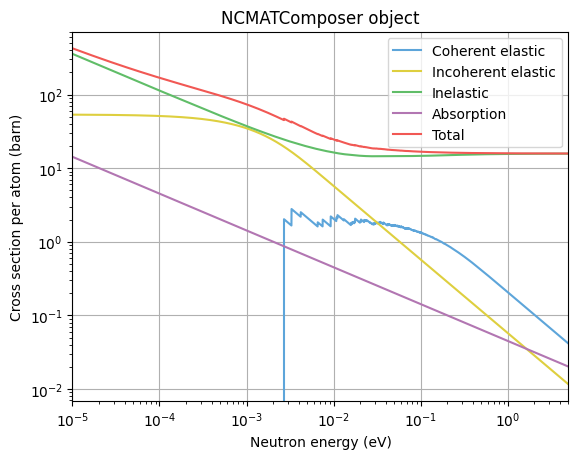

In [22]:
ncplot.plot_xsect(c_zrh, mode='ekin', xmin=1e-5, xmax=5)

We can check this by comparing with experimental total scattering cross section data. We will use three datasets from the [EXFOR database](https://www-nds.iaea.org/exfor/):
- Entry 23424, from Schmidt, Atomkernenergie Vol.12, p.385 (1967)
- Entry 14174 subentries 002 and 003, from Whittemore, report GA-4490 (1964)

Text(0, 0.5, 'Cross-section (b per atom)')

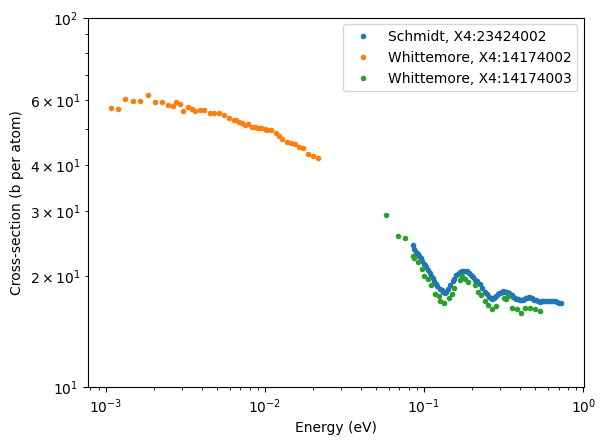

In [23]:
from urllib.request import urlopen, Request
import pandas as pd
import io

x4ids = [23424002,14174002, 14174003]
x4label = ['Schmidt','Whittemore','Whittemore']

experimental_data = [{'id':23424002, 'author':'Schmidt',    'data':None},
                     {'id':14174002, 'author':'Whittemore', 'data':None},
                     {'id':14174003, 'author':'Whittemore', 'data':None}]


for entry in experimental_data:
    req = Request(
        url=f"https://nds.iaea.org/exfor/x4get?DatasetID={entry['id']}&op=csv",
        data=None,
        headers={
            'User-Agent': 'Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
        }
    )
    with urlopen(req) as f:
        df = pd.read_csv(io.StringIO(f.read().decode('utf-8')))
    if 'EN (EV) 1.1' in list(df):
        x4_E, x4_xs = df['EN (EV) 1.1'].values, df['DATA (B) 0.1'].values
    elif 'EN (MEV) 1.1' in list(df):
        x4_E, x4_xs = 1e6*df['EN (MEV) 1.1'].values, df['DATA (B) 0.1'].values
    entry['data'] = x4_E, x4_xs

fig, ax = plt.subplots()

for entry in experimental_data:
  xs = (2*entry['data'][1]+6.46+0.185*np.sqrt(0.0253/entry['data'][0]))/3.0
  plt.plot(entry['data'][0], xs, '.', label=f"{entry['author']}, X4:{entry['id']}")

ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10,100)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Cross-section (b per atom)")

And now we can compare:

Text(0, 0.5, 'Cross-section (b per atom)')

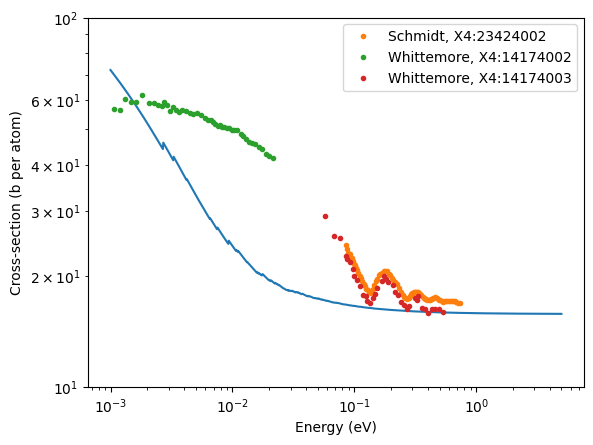

In [24]:
c_zrh.register_as('bad_zrh.ncmat')
E = np.geomspace(1e-3, 5, 1000)
zrh_nc = NC.load('bad_zrh.ncmat')
xs = zrh_nc.scatter.xsect(ekin=E)

fig, ax = plt.subplots()
plt.loglog(E,xs)

for entry in experimental_data:
  xs = (2*entry['data'][1]+6.46)/3.0
  plt.plot(entry['data'][0], xs, '.', label=f"{entry['author']}, X4:{entry['id']}")

ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10,100)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Cross-section (b per atom)")

We will replace this model with a vibrational density of states. We will add the VDOS data from Slaggie:

Slaggie, E. L. "Central force lattice dynamical model for zirconium hydride."
Journal of physics and chemistry of solids, 29, no. 6 (1968): 923-934.

https://doi.org/10.1016/0022-3697(68)90227-8

In [25]:
# H(ZrH) frequency spectra from Slaggie
vdos_txt_h = """0.002821997105643995	0.006502687801874032
0.003979739507959481	0.01370064460477991
0.005137481910274966	0.020898601407685645
0.00629522431259045	0.03527788675637225
0.007597684515195368	0.054686180619246585
0.008393632416787275	0.06762400392842423
0.009479015918958033	0.08415664857477623
0.010347322720694647	0.10571310540496284
0.01150506512301013	0.12583745359027446
0.012518089725036182	0.16175864604416346
0.01353111432706223	0.19767983849805262
0.014399421128798844	0.26088800089376873
0.015267727930535458	0.34707641463598393
0.01613603473227207	0.35427021437460865
0.017293777134587553	0.3499780455042648
0.018306801736613608	0.3327574067193747
0.01939218523878436	0.33420926141958546
0.020405209840810422	0.294008371288196
0.021490593342981187	0.1626056478914589
0.022575976845151953	0.14538604837263905
0.02351664254703329	0.1238555731942101
0.024384949348769905	0.09586086305850784
0.025470332850940677	0.06427860644812626
0.026049204052098415	0.10306609472390577
0.02648335745296672	0.12246191739393623
0.027568740955137484	0.1483302891498023
0.028581765557163533	0.07150462343493032
0.02937771345875543	0.014065426995455538
0.030752532561505078	0
0.10933429811866861	0.08511589115764195
0.11150506512301016	0.8063665439466376
0.11309696092619395	1.8140389257106335
0.1141823444283647	2.749170535767604
0.11526772793053548	3.6843021458245744
0.11613603473227209	4.690935261518291
0.11743849493487701	5.841818507769773
0.11845151953690308	7.207725903966576
0.11931982633863969	8.645238732407151
0.1201881331403763	9.508245277185196
0.1214182344428365	11.879850449612448
0.12235890014471784	13.461093775575677
0.12308248914616499	16.119224603584925
0.12438494934876992	19.496319699028547
0.1255426917510854	26.39205792869076
0.12655571635311147	29.62511074679061
0.12742402315484808	30.847183718857735
0.128726483357453	31.495373966904552
0.12959479015918962	31.56843437164673
0.1304630969609262	33.29320034191852
0.13140376266280754	35.73620309337544
0.13241678726483358	33.726886073055184
0.13350217076700435	36.17009667772618
0.13451519536903042	38.182323643043276
0.1357452966714906	38.54315682265184
0.13654124457308253	39.40605944082289
0.137698986975398	28.92298258969514
0.13856729377713461	23.25098015781255
0.1393632416787265	25.406521914224157
0.1405933429811867	26.485487948410807
0.14153400868306804	27.34859841979592
0.1426193921852388	27.637410460732596
0.1437771345875543	29.290778851974736
0.14450072358900146	25.772967130612358
0.1454413892908828	23.54810632731163
0.146671490593343	24.62707236149828
0.14732272069464541	27.500539119273952
0.14855282199710565	37.699792406602455
0.14978292329956588	60.53818393450545
0.15036179450072362	26.35589146944426
0.15166425470332853	18.458300748011723
0.15246020260492046	14.43789995505172
0.15369030390738067	11.567135289058854
0.15448625180897252	9.41387991800191
0.15549927641099862	7.5481894685972435
0.1565123010130246	5.682499019192619
0.1575253256150507	3.744995284330159
0.1583936324167873	1.017337556217754
0.16013024602026052	0.014445798377167307
"""

Text(0, 0.5, 'rho [a.u.]')

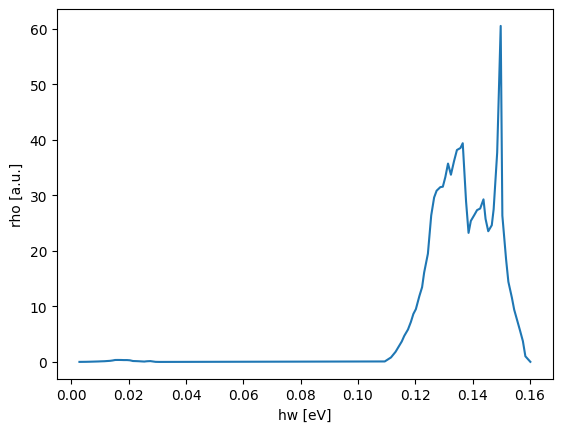

In [26]:
vdos_data_h = np.fromstring(vdos_txt_h, sep=' ')
vdos_data_h = np.reshape(vdos_data_h, (-1, 2))

plt.figure()
plt.plot(vdos_data_h[:,0], vdos_data_h[:,1])
plt.xlabel('hw [eV]')
plt.ylabel('rho [a.u.]')

In [27]:
# Zr(ZrH) frequency spectra from Slaggie
vdos_txt_zr = """0.0014290310018455488	0.6067092860407968
0.003700290498685376	1.1298246123257343
0.004960972553800305	1.8227401693648062
0.0059691311888193065	2.515002648593338
0.006807731473754738	3.637861097606077
0.007728087425349573	5.622999949205052
0.0087328597309803	7.522150222409266
0.009737148275269874	9.593713037610016
0.010907608840254743	12.441567677002183
0.01174112963110779	15.374757816978544
0.01281919177992729	21.153407977708255
0.013810902529346171	27.707696884818787
0.014787858557859065	39.52056832282362
0.015747641058760066	57.454085001705266
0.01657317978748364	63.23208208462435
0.01757166319567905	67.37259540378348
0.018827749518052758	69.70343010978962
0.019819460267471646	76.25771901690017
0.020836810367973066	73.6741431981946
0.021846904048356784	43.67675550943693
0.022944316650823485	42.55890399030541
0.023957554779924867	41.440834778570334
0.024979016851826304	37.39175235289419
0.025758114491796616	29.72135346748034
0.026665408887179602	66.36163095298564
0.02759713323029217	94.29507506766609
0.028707365508300137	58.60829118562647
0.02982751489380229	19.387050192657938
0.03088888727635107	1.1139330522679813
0.03232251401093784	0
"""

Text(0, 0.5, 'rho [a.u.]')

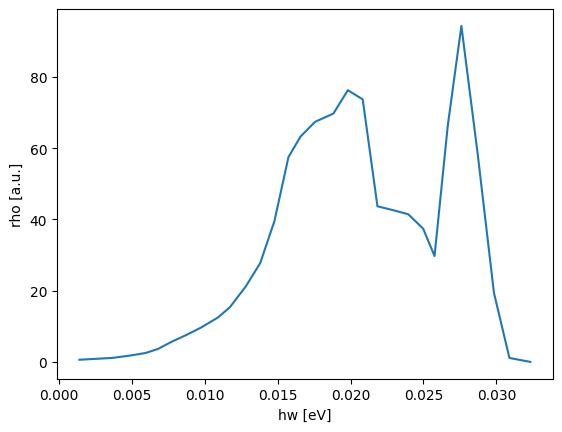

In [28]:
vdos_data_zr = np.fromstring(vdos_txt_zr, sep=' ')
vdos_data_zr = np.reshape(vdos_data_zr, (-1, 2))

plt.figure()
plt.plot(vdos_data_zr[:,0], vdos_data_zr[:,1])
plt.xlabel('hw [eV]')
plt.ylabel('rho [a.u.]')

We will use the NCrystal DOS phonon analyser to check to study the effect of low energy modes and find the right cutoff for the spectrum. Below this cutoff energy NCrystal will extrapolate the spectrum as a parabola.

In [29]:
dosana = NC.PhononDOSAnalyser([('H', vdos_data_h[:,0], vdos_data_h[:,1]), ('Zr', vdos_data_zr[:,0], vdos_data_zr[:,1])])

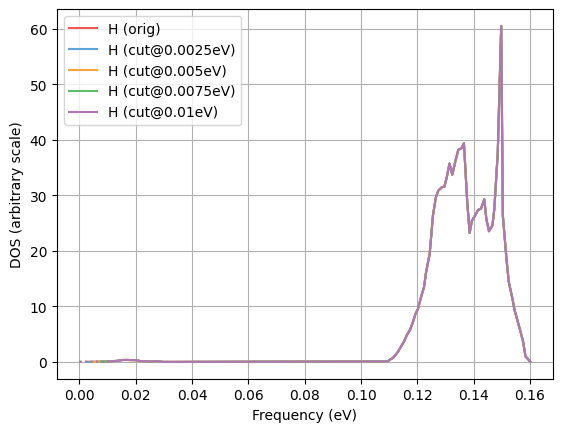

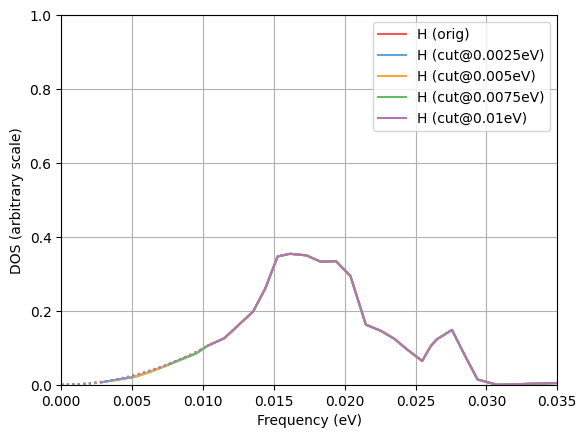

In [30]:
cutoff_candidates = np.linspace(0.0025,0.01,4)
dosana.plot_cutoff_effects(cutoff_candidates,'H')
#Zoom of the same plot:
dosana.plot_cutoff_effects(cutoff_candidates,'H',xmin=0.00,xmax=0.035,ymin=0,ymax=1)

$E_{cutoff} = 5$ meV is a reasonable value for the cutoff in both spectra.

In [31]:
E_cutoff = 0.005
dosana_final = dosana.apply_cutoff(E_cutoff)

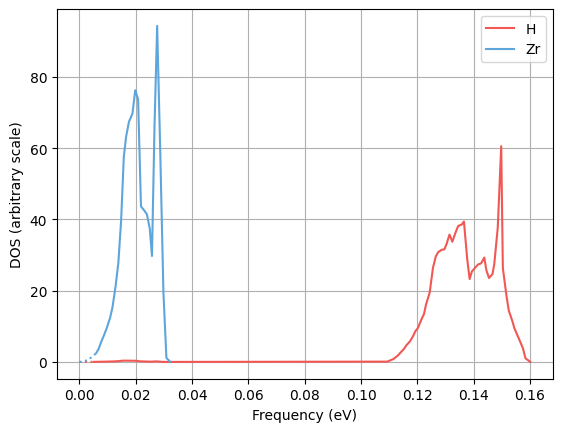

In [32]:
dosana_final.plot()

In [33]:
dosana_final.apply_to( c_zrh)
txt = """ ############################################

Vibrational density of states obtained from calculations by
Slaggie.

Slaggie, E. L. "Central force lattice dynamical model for
zirconium hydride." Journal of physics and chemistry of solids,
 29, no. 6 (1968): 923-934.

"""

c_zrh.add_comments(txt)

print(c_zrh())

NCMAT v7
# Autogenerated by NCMATComposer
#
# H2Zr (tetragonal, SG-139)
#
# Atoms per unit cell: 4xH+2xZr
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   The Materials Project
#   https://www.materialsproject.org/materials/mp-24286
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
#  ############################################
#
# Vibrational density of states obtained from calculations by
# Slaggie.
#
# Slaggie, E. L. "Central force lattice dynamical model for
# zirconium hydride." Journal of physics and chemistry of solids,
#  29, no. 6 (1968): 923-934.
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  len

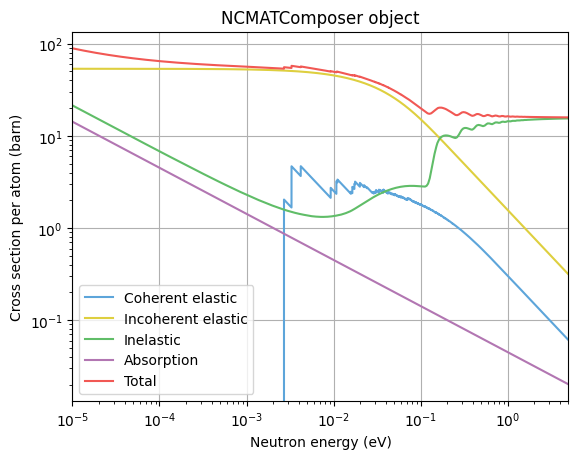

In [34]:
ncplot.plot_xsect(c_zrh, mode='ekin', xmin=1e-5, npts=20000, xmax=5)

We can now export an NCMAT file:

In [35]:
c_zrh.write('zrh.ncmat')

PosixPath('zrh.ncmat')

And test the cross section by comparing with experimental data:

Text(0, 0.5, 'Cross-section (b per atom)')

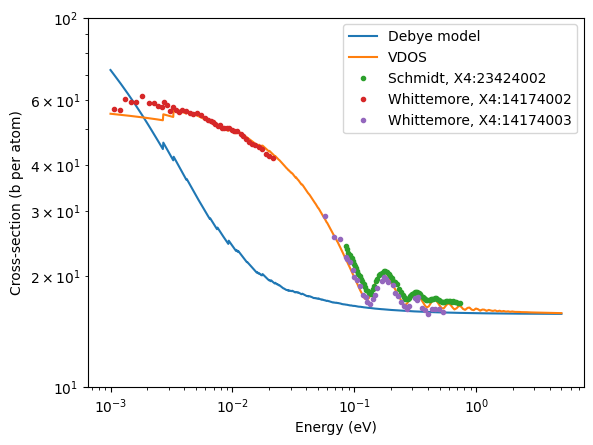

In [36]:
E = np.geomspace(1e-3, 5, 1000)

fig, ax = plt.subplots()

zrh_nc_bad = NC.load('bad_zrh.ncmat')
xs = zrh_nc_bad.scatter.xsect(ekin=E)
plt.loglog(E,xs, label='Debye model')

zrh_nc = NC.load('zrh.ncmat')
xs = zrh_nc.scatter.xsect(ekin=E)
plt.loglog(E,xs, label='VDOS')

for entry in experimental_data:
  xs = (2*entry['data'][1]+6.32)/3.0
  plt.plot(entry['data'][0], xs, '.', label=f"{entry['author']}, X4:{entry['id']}")

ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10,100)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Cross-section (b per atom)")

## OpenMC model with NCrystal materials

We can create the U-ZrH2 material as a combination of our recently created NCMAT file, and an incoherent solid model for U:

In [37]:
info_zrh = NC.createInfo('zrh.ncmat')
dens_zrh = info_zrh.density
dens_umet = 19 # g/cm3

vf_zrh  = (0.88/dens_zrh)/((0.88/dens_zrh)+(0.12/dens_umet))  # Volume fraction for ZrH2
vf_umet = (0.12/dens_umet)/((0.88/dens_zrh)+(0.12/dens_umet)) # Volume fraction for U
cfg = f'phases<{vf_zrh}*zrh.ncmat&{vf_umet}*solid::U/{dens_umet}gcm3/U_is_0.20_U235_0.80_U238>;density=6.128gcm3'

With this configuration string we can create an OpenMC material object and plot it:

Text(0, 0.5, 'Macro XS [cm^-1]')

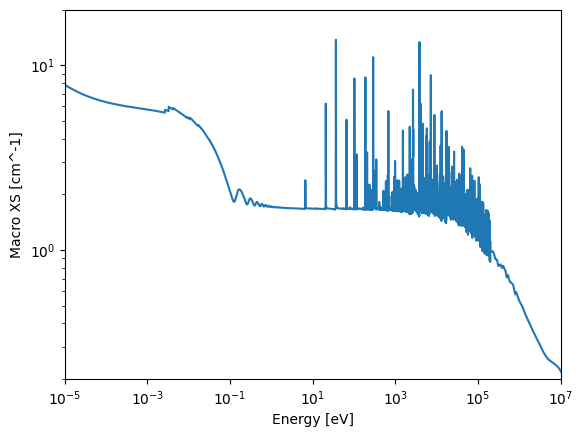

In [38]:
nc_uzrh = openmc.Material.from_ncrystal(cfg)
E, xs = openmc.calculate_cexs(nc_uzrh, ['scatter'])
plt.loglog(E,xs[0])
plt.xlim(1e-5, 10e6)
plt.ylim(0.2, 20)
plt.xlabel('Energy [eV]')
plt.ylabel('Macro XS [cm^-1]')

Again, we can run the system for the temperatures we ran before and compare with the results using ENDF data:

In [39]:
nc_uzrh = openmc.Material.from_ncrystal(cfg+';temp=293K')
model = create_model(nc_uzrh)
model.export_to_xml()

In [40]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
ncmat_results.append((nc_uzrh.temperature, sp.keff.nominal_value,sp.keff.std_dev))

runtime = 49.59 s
keff = 1.3347+/-0.0005


In [41]:
nc_uzrh = openmc.Material.from_ncrystal(cfg+';temp=323K')
model = create_model(nc_uzrh)
model.export_to_xml()

In [42]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
ncmat_results.append((nc_uzrh.temperature, sp.keff.nominal_value,sp.keff.std_dev))

runtime = 50.10 s
keff = 1.3328+/-0.0005


In [43]:
nc_uzrh = openmc.Material.from_ncrystal(cfg+';temp=373K')
model = create_model(nc_uzrh)
model.export_to_xml()

In [44]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
ncmat_results.append((nc_uzrh.temperature, sp.keff.nominal_value,sp.keff.std_dev))

runtime = 54.82 s
keff = 1.3277+/-0.0004


But, with the NCMAT file we are not limited in the temperature range:

In [45]:
nc_uzrh = openmc.Material.from_ncrystal(cfg+';temp=275K')
model = create_model(nc_uzrh)
model.export_to_xml()

In [46]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
ncmat_results.append((nc_uzrh.temperature, sp.keff.nominal_value,sp.keff.std_dev))

runtime = 53.52 s
keff = 1.3360+/-0.0004


Text(0, 0.5, 'Multiplication factor')

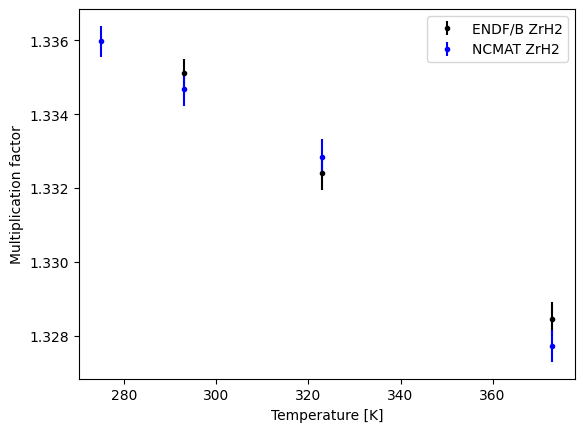

In [47]:
T, k, err = zip(*endf_results)
plt.errorbar(T, k, yerr=err, fmt='k.', label='ENDF/B ZrH2')
T, k, err = zip(*ncmat_results)
plt.errorbar(T, k, yerr=err, fmt='b.', label='NCMAT ZrH2')
plt.legend()
plt.xlabel('Temperature [K]')
plt.ylabel('Multiplication factor')

## Create ENDF-6 files

We will use the `ncmat2endf` script to generate the ENDF-6 files. The scripts generates the data ($S(\alpha, \beta)$ tables, Bragg edges, effective temperatures,...) using NCrystal and then uses the [`endf-parserpy`](https://endf-parserpy.readthedocs.io/) from IAEA to convert the data to the ENDF-6 format.

In [48]:
#
# We have to download the script because it is not yet part of the official NCrystal distribution.
#
!wget -O ncrystal_ncmat2endf.py "https://raw.githubusercontent.com/marquezj/ncmat2endf/refs/heads/main/ncrystal_ncmat2endf.py"
!chmod +x ncrystal_ncmat2endf.py
import sys
python_exec = sys.executable
with open('ncrystal_ncmat2endf.py', 'r') as f:
  txt = ''.join(f.readlines())
  txt = txt.replace('python3', python_exec)
with open('ncrystal_ncmat2endf.py', 'w') as f:
  f.write(txt)

--2024-10-31 11:44:27--  https://raw.githubusercontent.com/marquezj/ncmat2endf/refs/heads/main/ncrystal_ncmat2endf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46928 (46K) [text/plain]
Saving to: ‘ncrystal_ncmat2endf.py’

ncrystal_ncmat2endf 100%[===================>]  45.83K   183KB/s    in 0.2s    

2024-10-31 11:44:29 (183 KB/s) - ‘ncrystal_ncmat2endf.py’ saved [46928/46928]



In [49]:
!./ncrystal_ncmat2endf.py --help

usage: ncrystal_ncmat2endf.py [-h] [-n NAME] [-t TEMPERATURES [TEMPERATURES ...]] [-e {greater,scaled,mixed}]
                              [-v VERBOSITY] [-l {1,2,3,4,5}] [-g] [-i] [-m MATS] [--alab ALAB] [--auth AUTH]
                              [--libname LIBNAME] [--nlib NLIB] [--smin SMIN] [--lasym {0,1,2,3}]
                              input

Script for creating a set of ENDF-6 thermal scattering files from a .ncmat
file. Parameters for the ENDF-6 file can be defined with command line arguments or
changing the endf_defaults dictionary in the script. 

The script allows to handle multiple temperatures in one ENDF-6 file, but this is not
recommended, because NCrystal computes an optimal (alpha, beta) grid for each material
and temperature.

Ths script uses the endf-parserpy package from IAEA to format and check the syntaxis of
the ENDF-6 file.

positional arguments:
  input                 NCMAT file to convert

options:
  -h, --help            show this help message and exit
 

In [50]:
!./ncrystal_ncmat2endf.py zrh.ncmat --alab ESS --name ZrH2 --smin=3e-98 --temperatures 275 -m '{"Zr":98, "H": 99}'

Get nuclear data...
Write ENDF file tsl_H_in_ZrH2.endf...
Write ENDF file tsl_Zr_in_ZrH2.endf...
Files created:
  tsl_H_in_ZrH2.endf
  tsl_Zr_in_ZrH2.endf


In [51]:
!wget -O endf2ace.py "https://git.esss.dk/spallation-physics-group/endf2ace/-/raw/main/endf2ace.py"
!chmod +x endf2ace.py
import sys
python_exec = sys.executable
with open('endf2ace.py', 'r') as f:
  txt = ''.join(f.readlines())
  txt = txt.replace('python3', python_exec)
with open('endf2ace.py', 'w') as f:
  f.write(txt)

--2024-10-31 11:44:41--  https://git.esss.dk/spallation-physics-group/endf2ace/-/raw/main/endf2ace.py
Resolving git.esss.dk (git.esss.dk)... 130.226.136.138
Connecting to git.esss.dk (git.esss.dk)|130.226.136.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12559 (12K) [text/plain]
Saving to: ‘endf2ace.py’

endf2ace.py         100%[===================>]  12.26K  --.-KB/s    in 0.001s  

2024-10-31 11:44:42 (17.4 MB/s) - ‘endf2ace.py’ saved [12559/12559]



In [52]:
!./endf2ace.py --help

usage: endf2ace.py [-h] [-n NAME] [-s SUFFIX] [--acefile ACEFILE] [--acename ACENAME] [--njoy_exec NJOY_EXEC]
                   [-t TEMPERATURE] [--zaids ZAIDS [ZAIDS ...]]
                   input

Script for processing ENDF-6 TSL files into ACE files using NJOY.

positional arguments:
  input                 ENDF-6 TSL to convert

options:
  -h, --help            show this help message and exit
  -n, --name NAME       Name of the compound (default: None)
  -s, --suffix SUFFIX   Suffix for the ACE identifier (default: None)
  --acefile ACEFILE     ACE filename (default: None)
  --acename ACENAME     ACE identifier (default: None)
  --njoy_exec NJOY_EXEC
                        NJOY executable (default: njoy)
  -t, --temperature TEMPERATURE
                        Temperature to process the ENDF-6 file. If none is given, it will process the first
                        temperature of the file (default: None)
  --zaids ZAIDS [ZAIDS ...]
                        ZAIDs to assign the ACE 

In [53]:
!time ./endf2ace.py --acefile hzrh2.ace --acename hzrh2 tsl_H_in_ZrH2.endf

Wrote hzrh2.ace, hzrh2.xsdir

real	0m50.961s
user	0m50.140s
sys	0m0.728s


In [54]:
fn = 'hzrh2.ace'
data = openmc.data.ThermalScattering.from_ace(fn)

In [55]:
data.export_to_hdf5('hzrh2.h5')
!mkdir -p '/home/marquezj/work/data/endfb-viii.0-hdf5/additional_libs/'
!mv 'hzrh2.h5' '/home/marquezj/work/data/endfb-viii.0-hdf5/additional_libs/'

In [56]:
!time ./endf2ace.py --acefile zrzrh2.ace --acename hzrh2 tsl_Zr_in_ZrH2.endf

Wrote zrzrh2.ace, zrzrh2.xsdir

real	0m20.927s
user	0m20.674s
sys	0m0.237s


In [57]:
fn = 'zrzrh2.ace'
data = openmc.data.ThermalScattering.from_ace(fn, name='c_Zr_in_ZrH2')

In [58]:
data.export_to_hdf5('zrzrh2.h5')
!mkdir -p '/home/marquezj/work/data/endfb-viii.0-hdf5/additional_libs/'
!mv 'zrzrh2.h5' '/home/marquezj/work/data/endfb-viii.0-hdf5/additional_libs/'

In [59]:
lib = openmc.data.DataLibrary.from_xml('/home/marquezj/work/data/endfb-viii.0-hdf5/cross_sections.xml.bak')
lib.register_file('/home/marquezj/work/data/endfb-viii.0-hdf5/additional_libs/hzrh2.h5')
lib.register_file('/home/marquezj/work/data/endfb-viii.0-hdf5/additional_libs/zrzrh2.h5')
lib.export_to_xml(openmc.config['cross_sections'])

In [60]:
# 20% enriched uranium zirconium hydride fuel: 12 w% U + 88 w% ZrH2

uzrh = openmc.Material(name='UZrH')
uzrh.set_density('g/cm3', 6.128)
uzrh.add_nuclide('U235', 3.506972E-03, 'ao')
uzrh.add_nuclide('U238', 1.402789E-02, 'ao')
uzrh.add_element('H',    6.549768E-01, 'ao')
uzrh.add_element('Zr',   3.274884E-01, 'ao')
uzrh.temperature = 275 # K
uzrh.add_s_alpha_beta('c_H_in_ZrH2')
uzrh.add_s_alpha_beta('c_Zr_in_ZrH2')

model = create_model(uzrh)
model.export_to_xml()

In [61]:
!rm *.h5
openmc.run(output=False)
sp = openmc.StatePoint('statepoint.100.h5')
print(f'runtime = {sp.runtime["total"]:.2f} s')
print(f'keff = {sp.keff}')
ncmat2endf_results.append((uzrh.temperature, sp.keff.nominal_value,sp.keff.std_dev))

runtime = 36.32 s
keff = 1.3371+/-0.0004


Text(0, 0.5, 'Multiplication factor')

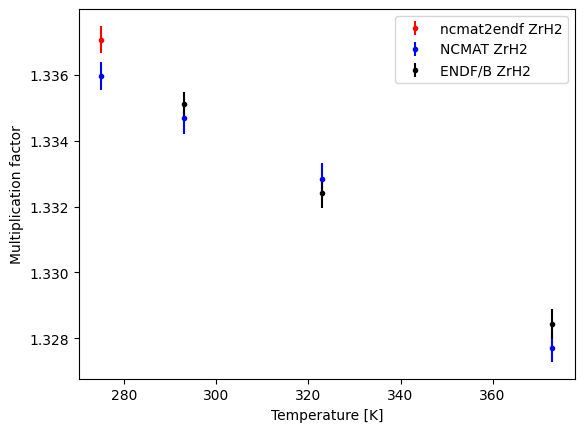

In [62]:
T, k, err = zip(*ncmat2endf_results)
plt.errorbar(T, k, yerr=err, fmt='r.', label='ncmat2endf ZrH2')
T, k, err = zip(*ncmat_results)
plt.errorbar(T, k, yerr=err, fmt='b.', label='NCMAT ZrH2')
T, k, err = zip(*endf_results)
plt.errorbar(T, k, yerr=err, fmt='k.', label='ENDF/B ZrH2')
plt.legend()
plt.xlabel('Temperature [K]')
plt.ylabel('Multiplication factor')

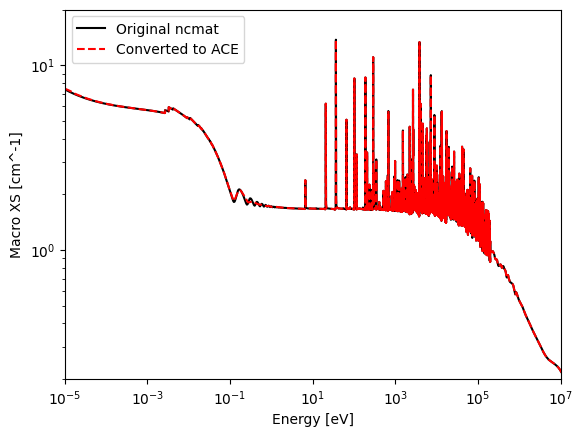

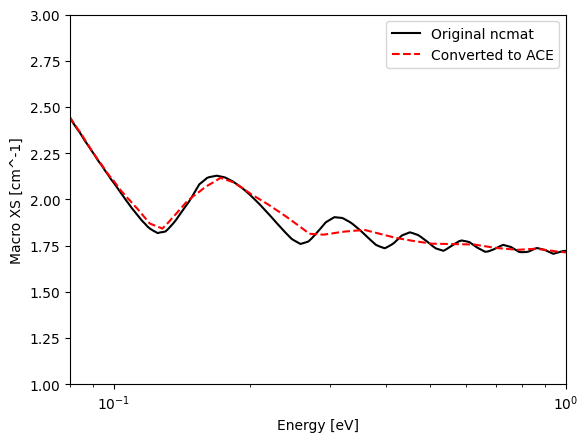

In [63]:
nc_uzrh = openmc.Material.from_ncrystal(cfg+';temp=275K')
E1, xs1 = openmc.calculate_cexs(nc_uzrh, ['scatter'])
plt.loglog(E1,xs1[0], 'k-', label='Original ncmat')

E2, xs2 = openmc.calculate_cexs(uzrh, ['scatter'])
plt.loglog(E2,xs2[0], 'r--', label='Converted to ACE')

plt.xlim(1e-5, 10e6)
plt.ylim(0.2, 20)
plt.xlabel('Energy [eV]')
plt.ylabel('Macro XS [cm^-1]')
plt.legend()

plt.figure()

plt.semilogx(E1,xs1[0], 'k-', label='Original ncmat')
plt.semilogx(E2,xs2[0], 'r--', label='Converted to ACE')

plt.xlim(0.08, 1.0)
plt.ylim(1, 3)
plt.xlabel('Energy [eV]')
plt.ylabel('Macro XS [cm^-1]')
plt.legend()